![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-907-6.gif)

このノートブックはオライリー・ジャパンより発行の書籍[『セキュリティエンジニアのための機械学習』](https://www.oreilly.co.jp/books/978487311XXXX/)のサンプルコードです。コードの解説等は書籍をご参照ください。なお、このコードを動作させた結果について、著者およびオライリー・ジャパンは一切の責任を負いません。

## ファイルのメタデータを特徴量にしたマルウェア検出



### 最初にpandas-profilingを更新して、ランタイムを再起動しておく

In [1]:
!pip install -U pandas-profiling

     |████████████████████████████████| 248 kB 5.2 MB/s 
     |████████████████████████████████| 102 kB 54.1 MB/s 
     |████████████████████████████████| 62 kB 734 kB/s 
     |████████████████████████████████| 675 kB 56.0 MB/s 
     |████████████████████████████████| 3.1 MB 37.7 MB/s 
     |████████████████████████████████| 10.1 MB 50.6 MB/s 
     |████████████████████████████████| 636 kB 40.9 MB/s 
     |████████████████████████████████| 812 kB 35.9 MB/s 
     |████████████████████████████████| 28.5 MB 47.6 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=a37c83bc6853ffb29e2c9aed424307a53e46cc0e608e8705045e382ae328b49e
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=92099fb009ab9dc57e211a1da2d765cd4e1e577017b0565f5c6bda69c429b167
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e

In [2]:
!wget https://github.com/oreilly-japan/ml-security-jp/raw/master/ch03/MalwareData.csv.gz

--2021-09-05 02:17:21--  https://github.com/oreilly-japan/ml-security-jp/raw/master/ch03/MalwareData.csv.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch03/MalwareData.csv.gz [following]
--2021-09-05 02:17:21--  https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch03/MalwareData.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11831806 (11M) [application/octet-stream]
Saving to: ‘MalwareData.csv.gz’

MalwareData.csv.gz  100%[===================>]  11.28M  --.-KB/s    in 0.1s    

2021-09-05 02:17:22 (107 MB/s) - ‘MalwareData.csv.g

In [3]:
!gzip -d MalwareData.csv.gz

In [4]:
!pip install optuna

     |████████████████████████████████| 302 kB 5.3 MB/s 
     |████████████████████████████████| 208 kB 36.2 MB/s 
     |████████████████████████████████| 80 kB 8.6 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 49 kB 4.5 MB/s 
     |████████████████████████████████| 111 kB 73.3 MB/s 
     |████████████████████████████████| 141 kB 52.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=a153063e63f5685707da3272f46146132011f70938d6ffd8325b8fd0f936f9db
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [5]:
import pandas as pd
MalwareDataset = pd.read_csv('MalwareData.csv', sep='|')

In [6]:
MalwareDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138047 entries, 0 to 138046
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Name                         138047 non-null  object 
 1   md5                          138047 non-null  object 
 2   Machine                      138047 non-null  int64  
 3   SizeOfOptionalHeader         138047 non-null  int64  
 4   Characteristics              138047 non-null  int64  
 5   MajorLinkerVersion           138047 non-null  int64  
 6   MinorLinkerVersion           138047 non-null  int64  
 7   SizeOfCode                   138047 non-null  int64  
 8   SizeOfInitializedData        138047 non-null  int64  
 9   SizeOfUninitializedData      138047 non-null  int64  
 10  AddressOfEntryPoint          138047 non-null  int64  
 11  BaseOfCode                   138047 non-null  int64  
 12  BaseOfData                   138047 non-null  int64  
 13 

In [7]:
import pandas_profiling

pandas_profiling.ProfileReport(MalwareDataset, minimal=True)

Summarize dataset:   0%|          | 0/65 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

(0.0, 26.0)

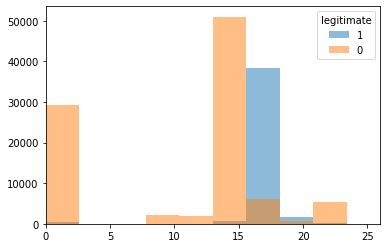

In [8]:
import matplotlib.pyplot as plt

plt.hist(MalwareDataset.loc[MalwareDataset['legitimate'] == 1, 'VersionInformationSize'], range=(0,26), alpha=0.5, label='1')
plt.hist(MalwareDataset.loc[MalwareDataset['legitimate'] == 0, 'VersionInformationSize'], range=(0,26), alpha=0.5, label='0')
plt.legend(title='legitimate')
plt.xlim(0,26)

(2.0, 11.0)

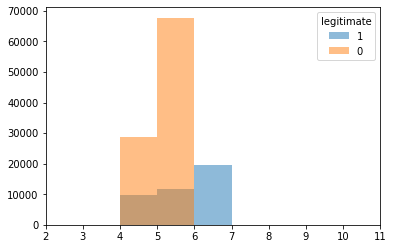

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(MalwareDataset.loc[MalwareDataset['legitimate'] == 1, 'MajorSubsystemVersion'], range=(0,10), alpha=0.5, label='1')
plt.hist(MalwareDataset.loc[MalwareDataset['legitimate'] == 0, 'MajorSubsystemVersion'], range=(0,10), alpha=0.5, label='0')
plt.legend(title='legitimate')
plt.xlim(2,11)

(0.0, 10000.0)

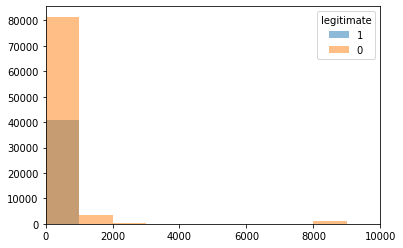

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(MalwareDataset.loc[MalwareDataset['legitimate'] == 1, 'SizeOfUninitializedData'], range=(0,10000), alpha=0.5, label='1')
plt.hist(MalwareDataset.loc[MalwareDataset['legitimate'] == 0, 'SizeOfUninitializedData'], range=(0,10000), alpha=0.5, label='0')
plt.legend(title='legitimate')
plt.xlim(0,10000)

In [11]:
print('The Number of features are  {} \n'.format(MalwareDataset.shape[1]))

The Number of features are  57 



In [12]:
MalwareDataset.columns

Index(['Name', 'md5', 'Machine', 'SizeOfOptionalHeader', 'Characteristics',
       'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
       'SizeOfInitializedData', 'SizeOfUninitializedData',
       'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase',
       'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion',
       'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion',
       'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfImage',
       'SizeOfHeaders', 'CheckSum', 'Subsystem', 'DllCharacteristics',
       'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve',
       'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'SectionsNb',
       'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy',
       'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize',
       'SectionsMeanVirtualsize', 'SectionsMinVirtualsize',
       'SectionMaxVirtualsize', 'ImportsNbDLL', 'ImportsNb',
       'Impor

In [13]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# データセットから名前、md5ハッシュ値、ラベルといった列を除外してXに代入
X = MalwareDataset.drop(['Name', 'md5', 'legitimate'],axis='columns')
# データセットのラベル列のみを抽出してyに代入
y = MalwareDataset['legitimate']
# ExtraTreesClassifierを使用
FeatSelect=ExtraTreesClassifier().fit(X, y)
# SelectFromModelを使用して、ExtraTreesClassifierによる分類結果に寄与した重要度の大きい特徴量のみを抽出
Model = SelectFromModel(FeatSelect, prefit=True)
# 重要度の大きい特徴量のカラム名を取得
feature_idx = Model.get_support()
feature_name = X.columns[feature_idx]
# Xに選択した特徴量のみを代入しなおす
X = Model.transform(X)
# 重要度の大きい特徴量のカラム名を設定
X = pd.DataFrame(X)
X.columns = feature_name

In [14]:
Features = X.shape[1]
# 重要度をリストで抽出
FI = ExtraTreesClassifier().fit(X,y).feature_importances_
# 重要度を高い順にソート
Index = np.argsort(FI)[::-1][:Features]
# 重要度の高い順に、特徴量の名前と重要度を出力
for feat  in range(Features):
    print("Feature: {}Importance: {:.5f}".format(MalwareDataset.columns[2+Index[feat]].ljust(30),FI[Index[feat]]))

Feature: SizeOfUninitializedData       Importance: 0.15535
Feature: Characteristics               Importance: 0.14022
Feature: Machine                       Importance: 0.12159
Feature: ImageBase                     Importance: 0.08456
Feature: MajorLinkerVersion            Importance: 0.08232
Feature: SizeOfInitializedData         Importance: 0.07278
Feature: AddressOfEntryPoint           Importance: 0.07045
Feature: BaseOfCode                    Importance: 0.06400
Feature: SizeOfCode                    Importance: 0.06059
Feature: BaseOfData                    Importance: 0.05807
Feature: SizeOfOptionalHeader          Importance: 0.04884
Feature: MinorLinkerVersion            Importance: 0.04123


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

# RandomForestClassifierのハイパーパラメータ探索用のクラスを設定
class Objective_RF:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, trial):
        # 探索対象のパラメータの設定
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
        bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
        max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
        min_samples_split = trial.suggest_int('min_samples_split', 2, 5)
        min_samples_leaf = trial.suggest_int('min_samples_leaf',1,10)

        model = RandomForestClassifier(
            criterion = criterion,
            bootstrap = bootstrap,
            max_features = max_features,
            min_samples_split = min_samples_split,
            min_samples_leaf = min_samples_leaf
        )

        # 交差検証しながらベストのパラメータ探索を行う
        scores = cross_validate(model,
                                X=self.X,
                                y=self.y,
                                cv=5,
                                n_jobs=-1)
        
        # 5分割で交差検証した正解率の平均値を返す
        return scores['test_score'].mean()

# 探索の対象クラスを設定
objective = Objective_RF(X, y)
study = optuna.create_study()
# 最大で3分間探索を実行
study.optimize(objective, timeout=180)
# ベストのパラメーターの出力
print('params:', study.best_params)

[I 2021-09-05 02:18:27,926] A new study created in memory with name: no-name-6a9cd0a8-af60-44e1-910a-bb155934ded0
[I 2021-09-05 02:19:05,085] Trial 0 finished with value: 0.9833968693236825 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9833968693236825.
[I 2021-09-05 02:19:39,345] Trial 1 finished with value: 0.9832954523317141 and parameters: {'criterion': 'gini', 'bootstrap': 'False', 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.9832954523317141.
[I 2021-09-05 02:20:15,792] Trial 2 finished with value: 0.9834403268522489 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9832954523317141.
[I 2021-09-05 02:20:50,278] Trial 3 finished with value: 0.9830853672491748 and parameters: {'criterion': 'entropy

params: {'criterion': 'entropy', 'bootstrap': 'True', 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 9}


In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# データセットをテスト用のデータに20%を割り当てて分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# optunaの探索結果として得られたベストのパラメーターを設定
model = RandomForestClassifier(
    criterion = study.best_params['criterion'],
    bootstrap = study.best_params['bootstrap'],
    max_features = study.best_params['max_features'],
    min_samples_split = study.best_params['min_samples_split'],
    min_samples_leaf = study.best_params['min_samples_leaf']
)

# モデルの訓練
model.fit(X_train, y_train)

# テスト用のデータを使用して予測
pred = model.predict(X_test)

# 予測結果とテスト用のデータを使って精度と、混同行列を出力
print("Accurary: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accurary: 99.10177 %
[[19343   123]
 [  125  8019]]


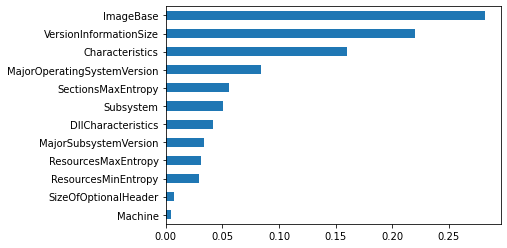

In [17]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
feat_importances.plot(kind='barh')

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

class Objective_GBC:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, trial):
        # 探索対象のパラメーターの指定
        max_depth=int(trial.suggest_loguniform("max_depth", 3, 10))
        max_features = trial.suggest_categorical("max_features", ["log2", "sqrt"])
        learning_rate = float(trial.suggest_loguniform("learning_rate", 1e-2, 1e-0))
        criterion =  trial.suggest_categorical("criterion", ["friedman_mse", "mse", "mae"])

        # モデルの初期化
        model = GradientBoostingClassifier(
            max_depth = max_depth,
            max_features = max_features,
            learning_rate = learning_rate,
            criterion=criterion
            )
        
        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                cv=5,
                                n_jobs=-1)
        return scores['test_score'].mean()

# 探索の対象クラスを設定
objective = Objective_GBC(X, y)
study = optuna.create_study()

# 最大で30秒探索を実行
study.optimize(objective, timeout=30)

# ベストのパラメーターの出力
print('params:', study.best_params)

[I 2021-09-05 02:27:53,750] A new study created in memory with name: no-name-ba8db835-6dba-424f-806e-c79cfa53832b
[I 2021-09-05 02:28:36,422] Trial 0 finished with value: 0.9827086986906949 and parameters: {'max_depth': 7.807988787972594, 'max_features': 'sqrt', 'learning_rate': 0.12555756059756815, 'criterion': 'mse'}. Best is trial 0 with value: 0.9827086986906949.


params: {'max_depth': 7.807988787972594, 'max_features': 'sqrt', 'learning_rate': 0.12555756059756815, 'criterion': 'mse'}


In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# データセットをテスト用のデータに20%を割り当てて分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# 探索結果として得られたベストのパラメーターを設定
model = GradientBoostingClassifier(
    criterion = study.best_params['criterion'],
    learning_rate = study.best_params['learning_rate'],
    max_depth = study.best_params['max_depth'],
    max_features = study.best_params['max_features']
)

# モデルの訓練
model.fit(X_train, y_train)

# テスト用のデータを使用して予測
pred = model.predict(X_test)

# 予測結果とテスト用のデータを使って正解率と、混同行列を出力
print("Accurary: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accurary: 99.23216 %
[[19351   115]
 [   97  8047]]


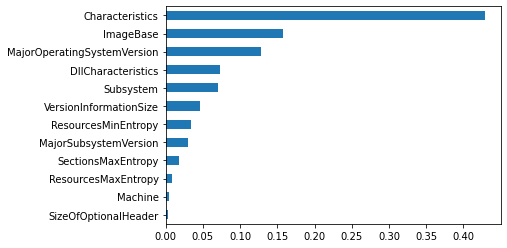

In [21]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
feat_importances.plot(kind='barh')

In [22]:
from sklearn.ensemble import AdaBoostClassifier

class Objective_ABC:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, trial):
        # 探索対象のパラメーターの指定
        algorithm =  trial.suggest_categorical("algorithm", ["SAMME", "SAMME.R"])
        learning_rate = float(trial.suggest_loguniform("learning_rate", 1e-2, 1e-0))

        # モデルの初期化
        model = AdaBoostClassifier(
            algorithm = algorithm,
            learning_rate = learning_rate
            )
        
        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                cv=5,
                                n_jobs=-1)
        return scores['test_score'].mean()

# 探索の対象クラスを設定
objective = Objective_ABC(X, y)
study = optuna.create_study()

# 最大で1分間探索を実行
study.optimize(objective, timeout=60)

# ベストのパラメーターの出力
print('params:', study.best_params)

[I 2021-09-05 02:28:47,414] A new study created in memory with name: no-name-63260bc0-716e-46c6-89da-a3b178a994f9
[I 2021-09-05 02:29:00,202] Trial 0 finished with value: 0.9547182727015736 and parameters: {'algorithm': 'SAMME', 'learning_rate': 0.013528243568030444}. Best is trial 0 with value: 0.9547182727015736.
[I 2021-09-05 02:29:12,986] Trial 1 finished with value: 0.9824334862171995 and parameters: {'algorithm': 'SAMME', 'learning_rate': 0.6653212186887072}. Best is trial 0 with value: 0.9547182727015736.
[I 2021-09-05 02:29:29,237] Trial 2 finished with value: 0.9832013404864106 and parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.6180961994032204}. Best is trial 0 with value: 0.9547182727015736.
[I 2021-09-05 02:29:45,571] Trial 3 finished with value: 0.9772613602567197 and parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.050756462623780856}. Best is trial 0 with value: 0.9547182727015736.
[I 2021-09-05 02:30:01,854] Trial 4 finished with value: 0.954580638522502

params: {'algorithm': 'SAMME.R', 'learning_rate': 0.019148145843472065}


In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# データセットをテスト用のデータに20%を割り当てて分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# 探索結果として得られたベストのパラメーターを設定
model = AdaBoostClassifier(
    algorithm = study.best_params['algorithm'],
    learning_rate = study.best_params['learning_rate']
)
# モデルの訓練
model.fit(X_train, y_train)

# テスト用のデータを使用して予測
pred = model.predict(X_test)

# 予測結果とテスト用のデータを使って正解率と、混同行列を出力
print("Accurary: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accurary: 95.36038 %
[[19214   252]
 [ 1029  7115]]


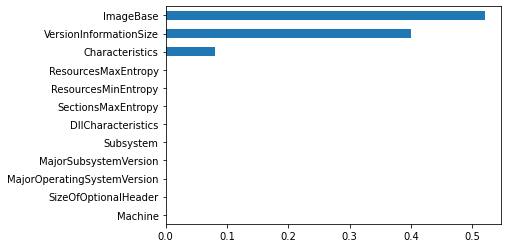

In [24]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
feat_importances.plot(kind='barh')

## Androidマルウェアのデータセットを使用した検出デモ

This dataset created & provided by following paper:
Urcuqui, C., & Navarro, A. (2016, April). Machine learning classifiers for android malware analysis. In Communications and Computing (COLCOM), 2016 IEEE Colombian Conference on (pp. 1-6). IEEE.

In [25]:
!wget https://github.com/oreilly-japan/ml-security-jp/raw/master/ch03/archive.zip

--2021-09-05 02:30:06--  https://github.com/oreilly-japan/ml-security-jp/raw/master/ch03/archive.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch03/archive.zip [following]
--2021-09-05 02:30:06--  https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch03/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9246 (9.0K) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>]   9.03K  --.-KB/s    in 0s      

2021-09-05 02:30:06 (56.9 MB/s) - ‘archive.zip’ saved [9246/9246]



In [26]:
!unzip -q archive.zip

In [27]:
import pandas as pd

# データセットのロード
AndroidDataset = pd.read_csv('train.csv', sep=';')

In [28]:
AndroidDataset.type.value_counts()

1    199
0    199
Name: type, dtype: int64

In [29]:
print(AndroidDataset.columns)

Index(['android', 'android.app.cts.permission.TEST_GRANTED',
       'android.intent.category.MASTER_CLEAR.permission.C2D_MESSAGE',
       'android.os.cts.permission.TEST_GRANTED',
       'android.permission.ACCESS_ALL_DOWNLOADS',
       'android.permission.ACCESS_ALL_EXTERNAL_STORAGE',
       'android.permission.ACCESS_BLUETOOTH_SHARE',
       'android.permission.ACCESS_CACHE_FILESYSTEM',
       'android.permission.ACCESS_CHECKIN_PROPERTIES',
       'android.permission.ACCESS_COARSE_LOCATION',
       ...
       'com.android.voicemail.permission.WRITE_VOICEMAIL',
       'com.foo.mypermission', 'com.foo.mypermission2',
       'org.chromium.chrome.shell.permission.C2D_MESSAGE',
       'org.chromium.chrome.shell.permission.DEBUG',
       'org.chromium.chrome.shell.permission.SANDBOX',
       'org.chromium.chromecast.shell.permission.SANDBOX',
       'org.chromium.content_shell.permission.SANDBOX', 'test_permission',
       'type'],
      dtype='object', length=331)


In [30]:
pd.Series.sort_values(AndroidDataset[AndroidDataset.type==1].sum(axis=0), ascending=False)[1:11]

android.permission.INTERNET                  195
android.permission.READ_PHONE_STATE          190
android.permission.ACCESS_NETWORK_STATE      167
android.permission.WRITE_EXTERNAL_STORAGE    136
android.permission.ACCESS_WIFI_STATE         135
android.permission.READ_SMS                  124
android.permission.WRITE_SMS                 104
android.permission.RECEIVE_BOOT_COMPLETED    102
android.permission.ACCESS_COARSE_LOCATION     80
android.permission.CHANGE_WIFI_STATE          75
dtype: int64

In [31]:
top10 = ['android.permission.INTERNET',
         'android.permission.READ_PHONE_STATE',
         'android.permission.ACCESS_NETWORK_STATE',
         'android.permission.WRITE_EXTERNAL_STORAGE',
         'android.permission.ACCESS_WIFI_STATE',
         'android.permission.READ_SMS',
         'android.permission.WRITE_SMS',
         'android.permission.RECEIVE_BOOT_COMPLETED',
         'android.permission.ACCESS_COARSE_LOCATION',
         'android.permission.CHANGE_WIFI_STATE']

In [32]:
AndroidDataset.loc[AndroidDataset.type==1, top10].sum()

android.permission.INTERNET                  195
android.permission.READ_PHONE_STATE          190
android.permission.ACCESS_NETWORK_STATE      167
android.permission.WRITE_EXTERNAL_STORAGE    136
android.permission.ACCESS_WIFI_STATE         135
android.permission.READ_SMS                  124
android.permission.WRITE_SMS                 104
android.permission.RECEIVE_BOOT_COMPLETED    102
android.permission.ACCESS_COARSE_LOCATION     80
android.permission.CHANGE_WIFI_STATE          75
dtype: int64

In [33]:
AndroidDataset.loc[AndroidDataset.type==0, top10].sum()

android.permission.INTERNET                  104
android.permission.READ_PHONE_STATE           24
android.permission.ACCESS_NETWORK_STATE       62
android.permission.WRITE_EXTERNAL_STORAGE     76
android.permission.ACCESS_WIFI_STATE          29
android.permission.READ_SMS                    4
android.permission.WRITE_SMS                   1
android.permission.RECEIVE_BOOT_COMPLETED     30
android.permission.ACCESS_COARSE_LOCATION     13
android.permission.CHANGE_WIFI_STATE          13
dtype: int64

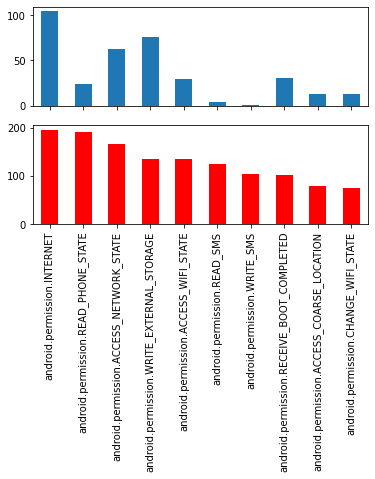

In [34]:
import matplotlib.pyplot as plt
fig, axs =  plt.subplots(nrows=2, sharex=True)

AndroidDataset.loc[AndroidDataset.type==0, top10].sum().plot.bar(ax=axs[0])
AndroidDataset.loc[AndroidDataset.type==1, top10].sum().plot.bar(ax=axs[1], color="red")

In [35]:
from sklearn.feature_selection import mutual_info_classif
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
import csv
import random

In [36]:
# X,yに特徴量とラベルをそれぞれ代入
X = AndroidDataset.iloc[:,:-1]
y = AndroidDataset.iloc[:, -1]

In [37]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate

# SVMのハイパーパラメータチューニング用のクラスを設定
class Objective_SVM:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, trial):
        # チューニング対象のパラメーターを指定
        params = {
            'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
            'C': trial.suggest_loguniform('C', 1e-5, 1e2),
            'gamma': trial.suggest_categorical('gamma', ['scale','auto']),
        }
        # モデルの初期化
        model = SVC(**params)

        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                n_jobs=-1)
        return scores['test_score'].mean()

# チューニングの対象クラスを設定
objective = Objective_SVM(X, y)
study = optuna.create_study(direction='maximize')
# 最大で1分間チューニングを実行
study.optimize(objective, timeout=60)
# ベストのパラメーターの出力
print('params:', study.best_params)

[I 2021-09-05 02:30:07,677] A new study created in memory with name: no-name-ba035189-45ab-4a1c-9b44-c73e5a51f167
[I 2021-09-05 02:30:07,935] Trial 0 finished with value: 0.909620253164557 and parameters: {'kernel': 'rbf', 'C': 0.21240069574062942, 'gamma': 'scale'}. Best is trial 0 with value: 0.909620253164557.
[I 2021-09-05 02:30:08,195] Trial 1 finished with value: 0.9272151898734178 and parameters: {'kernel': 'rbf', 'C': 3.1365242223480942, 'gamma': 'auto'}. Best is trial 1 with value: 0.9272151898734178.
[I 2021-09-05 02:30:08,570] Trial 2 finished with value: 0.7274683544303798 and parameters: {'kernel': 'rbf', 'C': 0.0029365455400828418, 'gamma': 'scale'}. Best is trial 1 with value: 0.9272151898734178.
[I 2021-09-05 02:30:08,812] Trial 3 finished with value: 0.9247151898734177 and parameters: {'kernel': 'rbf', 'C': 0.9539738223589459, 'gamma': 'scale'}. Best is trial 1 with value: 0.9272151898734178.
[I 2021-09-05 02:30:09,006] Trial 4 finished with value: 0.942246835443038 an

params: {'kernel': 'rbf', 'C': 75.003942593043, 'gamma': 'auto'}


In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# データセットをテスト用のデータに20%を割り当てて分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# 探索結果として得られたベストのパラメーターを設定

model = SVC(
    kernel = study.best_params['kernel'],
    C = study.best_params['C'],
    gamma = study.best_params['gamma']
)
# モデルの訓練
model.fit(X_train, y_train)
# テスト用のデータを使用して予測
pred = model.predict(X_test)
# 予測結果とテスト用のデータを使って精度と、混同行列を出力
print("Accurary: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accurary: 91.25000 %
[[36  2]
 [ 5 37]]
